# Ideas and thoughts

## Log

2025-07-10 
I am formally starting the project.
I have been looking the last while a bit at the available transportation data for Denmark.
I think it might be interesting to work with railroad data to begin with.
However, for learnings' sake I would be really interested in using open street map, as that seems to be a very nice thing to be proficient with.

Reviewing lecture 9.

2025-07-11
Continuing work. Feeling a bit lost.
Downloading data from dataforsyningen.dk 
https://dataforsyningen.dk/data/2689.
This is data over railways in Denmark.
I'm trying to create a population density object.


I have gotten this data on the number of residents:
https://geodata-info.dk/srv/dan/catalog.search#/metadata/41e8458f-87f4-401b-b805-ce3f14936f8b

https://dataforsyningen.dk/data/4875#origin

And this shape data:
https://datafordeler.dk/dataoversigt/danske-stednavne/danske-stednavne-fildownload-webbruger/

First, I want to merge these data frames. However, there are many more rows in 'bebyggelsesdata'.
I find out that this is because there is data for multiple years in 'bebyggelsesdata'.
I assume the data is complete (as that is what dataforsyningens says), and so I can just filter out all the other years.

In [1]:
import os
os.environ['PROJ_LIB'] = '/opt/conda/share/proj'

In [83]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx
import contextily as cx
import matplotlib.pyplot as plt
import os

Variables

In [3]:
datadir = "data"
fp_trains = "inspire-jernbane.gpkg"
fp_indbyggertal= "indbyggertal.csv"

fp_stednavne = "DS_V1_Stednavn_TotalDownload_gpkg_Bitemporal_331.gpkg"
stednavnedir = "DKstednavneBearbejdedeNohist_GPKG_HF_20250706080013"

Helper functions

In [57]:
join = lambda a, b : os.path.join(a, b)
grf = lambda name : gpd.read_file(join(datadir, name))
prlen = lambda df : print(len(df.index))
li = lambda df : len(df.index)
def mergecol(df, a, b, newname) :
    df = df.drop(b, axis=1)
    return df.rename(columns={a : newname})

The raw data we are working with

In [16]:
bebyggelse_raw = grf(join(stednavnedir, "bebyggelse.gpkg"))
indbyggertal_raw = pd.read_csv(join(datadir, fp_indbyggertal), sep=';')

In [25]:
print("Initial number of records in 'bebyggelse': ", li(bebyggelse_raw))
bebyggelse = bebyggelse_raw[['id_lokalid', 'navn_1_skrivemaade', 'bebyggelseskode', 'geometry']]
bebyggelse = bebyggelse.dropna(axis=0, subset='bebyggelseskode')
print("Records in 'bebyggelse' with a 'bebyggelseskode': ", li(bebyggelse))

print("Initial number of records in 'indbyggertal': ", li(indbyggertal_raw))
indbyggertal = indbyggertal_raw[indbyggertal_raw['optaellingsdato'] == '2024/01/01']
print("Records in 'indbyggertal' from 2024: ", li(indbyggertal))
indbyggertal = indbyggertal.drop(['optaellingsdato'], axis=1)
print("Ratio: ", li(indbyggertal_raw)/li(indbyggertal))
print("This should be 9, as there appears to be recordings of the numbers for nine years (2024--2016)")

Initial number of records in 'bebyggelse':  17858
Records in 'bebyggelse' with a 'bebyggelseskode':  8462
Initial number of records in 'indbyggertal':  75807
Records in 'indbyggertal' from 2024:  8459
Ratio:  8.961697600189147
This should be 9, as there appears to be recordings of the numbers for nine years (2024--2016)


In [79]:
merged = bebyggelse.merge(indbyggertal, left_on='id_lokalid', right_on='stednavne_uuid')
merged['bebyggelseskode_x'] = pd.to_numeric(merged['bebyggelseskode_x'], downcast='integer')
merged['bebyggelseskode_y'] = pd.to_numeric(merged['bebyggelseskode_y'], downcast='integer')
print("By definition of inner join, the two id fields are now equivalent, and can be merged")
print()

merged = mergecol(merged, 'stednavne_uuid', 'id_lokalid', 'id')
#merged[['cause', 'region', 'park']] = smallertypes[['cause', 'region', 'park']].astype('category')
#merged['ID'] = pd.util.hash_array(smallertypes['ID'].to_numpy())
print("'bebyggelseskode' fields are equivalent: ", merged['bebyggelseskode_x'].equals(merged['bebyggelseskode_y']))
merged = mergecol(merged, 'bebyggelseskode_y', 'bebyggelseskode_x', 'code')
print("So they are merged")
print()

print("'bebyggelseskode' fields are equivalent: ", merged['skrivemaade'].equals(merged['navn_1_skrivemaade']))
print("Let's investigate the difference:")
print("Number of differing entries: ",li(diff))
print()
diff = merged[merged['skrivemaade'] != merged['navn_1_skrivemaade']]
print(diff[['skrivemaade', 'navn_1_skrivemaade']])
print()

print("Acceptable difference - we will keep the 'skrivemaade' field")
merged = mergecol(merged, 'skrivemaade', 'navn_1_skrivemaade', 'name')
print()
print("Records in 'merged': ", li(merged))
print("Only very few records from either data entry has not been included here")

By definition of inner join, the two id fields are now equivalent, and can be merged

'bebyggelseskode' fields are equivalent:  True
So they are merged

'bebyggelseskode' fields are equivalent:  False
Let's investigate the difference:
Number of differing entries:  2

            skrivemaade navn_1_skrivemaade
423   Fjaltring Ferieby               None
8260      Remmer Strand       Remmerstrand

Acceptable difference - we will keep the 'skrivemaade' field

Records in 'merged':  8457
Only very few records from either data entry has not been included here


,geometry,id,name,code,tot_indb,tot_hus
7691,MULTIPOLYGON Z (((469108.300 6208218.690 0.000...,12337669-a869-6b98-e053-d480220a5a3f,Hanning,17788,151,64
1060,MULTIPOLYGON Z (((459799.760 6183656.620 0.000...,12337669-a09f-6b98-e053-d480220a5a3f,Lydum,17593,82,44


I am also curious how much of the total danish population is captured in this data.

In [97]:
merged['tot_indb'].sum()

5510986

This result is close enough to the official population of Denmark that it seems valid to me to use.
Just under half a million people are not registered here, but I also have no idea how this data and the official population statistics of Denmark differ in how they handle Danish people living abroad, undocumented immigrants, homelessness, and other equivalent things.

In [91]:
trains = grf(fp_trains)

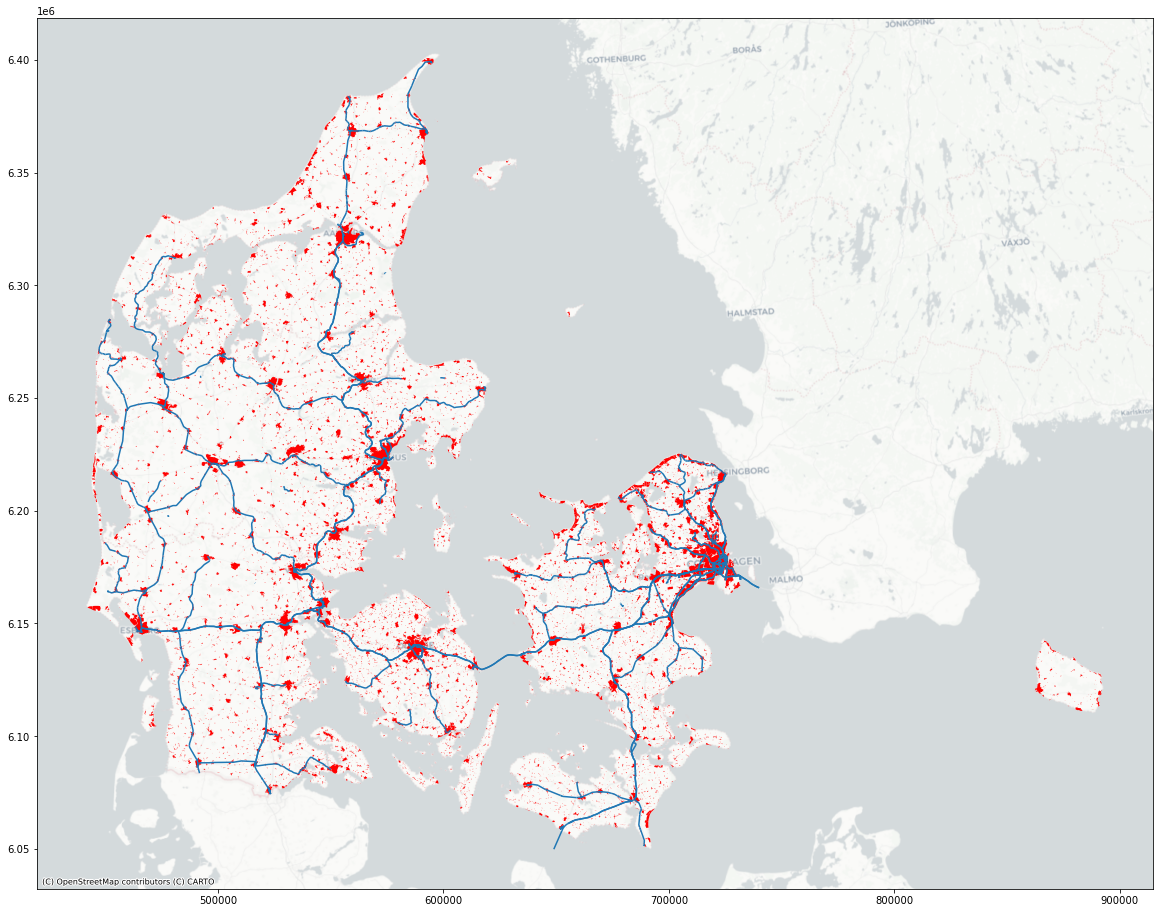

In [96]:
ax = merged.plot(color="red", figsize=(20, 30))
trains.plot(ax=ax)
cx.add_basemap(ax, crs=merged.crs, source=cx.providers.CartoDB.Positron)

At this point I want to make a population density map.
I have found one with a

In [ ]:
trains.explore()